# Demo: NAS with graph morphisms

In [1]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import time
from torchviz import make_dot

In [2]:
print("pytorch",torch.__version__)
print("cuda", torch.version.cuda)
print("cudnn", torch.backends.cudnn.version())
torch.cuda.is_available()


pytorch 1.3.1
cuda 10.0.130
cudnn 7605


True

## Set_up parameters and train/test functions

In [3]:
INPUT_SIZE = 28
INPUT_CHN = 1

N_CLASS = 10

BATCH_SIZE = 100
LEARNING_RATE = 1e-4

MNIST_NAMES = "0123456789"

In [4]:
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [5]:
def train_net(net, optimizer, n_epoch=10, criterion=F.cross_entropy, display_interval=100):
    net.train(True)
    
    print("Training...")
    t0 = time.time()
    optimizer.zero_grad()

    for epoch in range(n_epoch):
        cumul_loss = 0.0
        running_loss = 0.0
        for batch_idx, (X, y) in enumerate(train_loader):
            X = X.cuda()
            y = y.cuda()

            y_pred = net(X)

            loss = criterion(y_pred, y)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            running_loss += loss.item()
            cumul_loss += loss.item()

            batch_idx += 1
            if batch_idx % display_interval == 0:
                running_loss /= display_interval
                t1 = time.time()
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.4f}\tt={:.1f}s'.format(
                    epoch, batch_idx * len(X), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), running_loss, t1-t0))
                running_loss = 0

        cumul_loss /= batch_idx
        t1 = time.time()
        print('====> Epoch: {} done in {:.1f}s, Average loss: {:.4f}'.format(
            epoch, t1-t0, cumul_loss))
        t0 = t1

In [6]:
def test_net(net, use_train=False, criterion=F.cross_entropy, proba_extractor = lambda x:x):
    net.eval()

    if use_train:
        print("\nEvaluate net on TRAIN:")
        dataloader = train_loader
    else:
        print("\nEvaluate net on TEST:")
        dataloader = test_loader
    n_in_dataset = len(dataloader.dataset)
    
    cumul_loss = 0.0
    class_ok = 0
    with torch.no_grad():
        for batch_idx, (X, y) in enumerate(dataloader):
            X = X.cuda()
            ground_truth = y.numpy()
            y = y.cuda()

            net_output = net(X)
            cumul_loss += criterion(net_output, y).item()
            
            y_soft = proba_extractor(net_output)
            _, y_hard = y_soft.max(1)

            prediction = y_hard.cpu().numpy()
            class_ok += np.sum(ground_truth == prediction)

    cumul_loss /= batch_idx+1
    accuracy = class_ok / n_in_dataset
    print("Well classified %5d / %5d, (%5.2f%% accuracy)" % (
        class_ok, n_in_dataset, 100*accuracy))
    print("Average loss : %f" % cumul_loss)
    return cumul_loss, accuracy

## Sample test
Just train a simple network to check that `train_net` and `test_net` work as expected, and get a baseline for what level of accuracy can be expected

In [7]:
loader = iter(train_loader)
X,y = loader.next()
X_=X.numpy()[:,0,:,:]

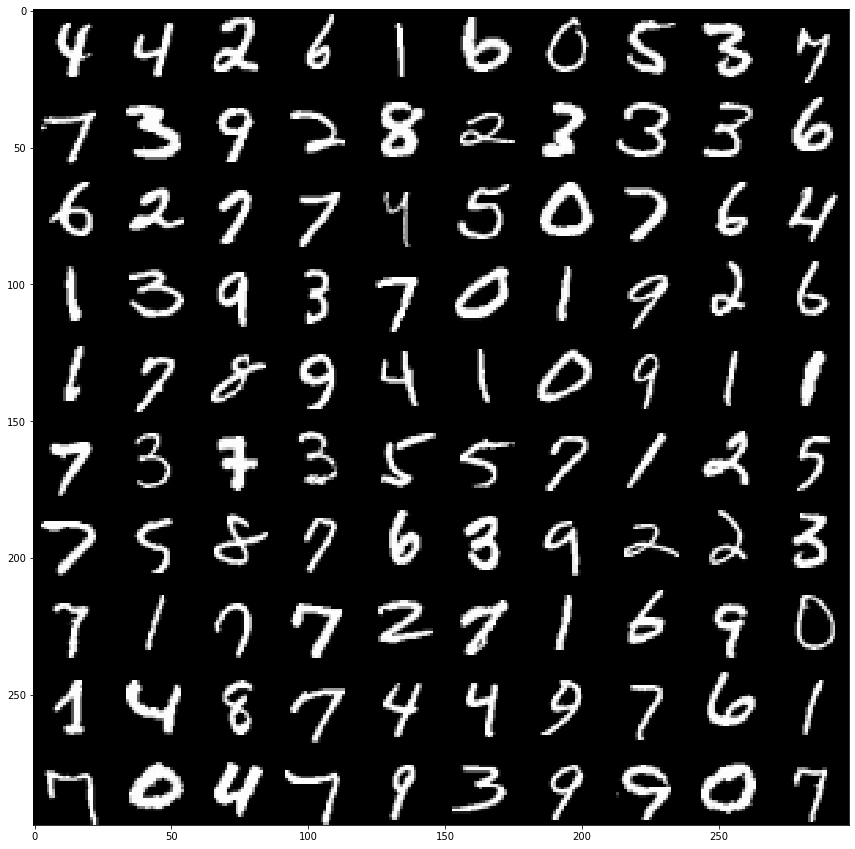

In [8]:
h, w = INPUT_SIZE, INPUT_SIZE
image = np.zeros(((h+2)*10-2, (w+2)*10-2))
img_labels = []
for ii in range(10):
    for jj in range(10):
        a = ii*(h+2)
        b = jj*(w+2)
        data = X_[jj+10*ii]
        image[a:a+h, b:b+w] = data
plt.figure(figsize=(15, 15))
plt.imshow(image,cmap='gray')

In [9]:
net01 = nn.Sequential(nn.Conv2d(1, 32, (5, 5), bias=True, padding=2, padding_mode='replicate'),
                    nn.ReLU(),
                    nn.MaxPool2d(2, stride=2),
                    nn.Conv2d(32, 64, (3, 3), bias=True, padding=1,
                              padding_mode='replicate'),
                    nn.ReLU(),
                    nn.Conv2d(64, 64, (3, 3), bias=True, padding=1,
                              padding_mode='replicate'),
                    nn.ReLU(),
                    nn.MaxPool2d(2, stride=2),
                    nn.Conv2d(64, 128, (3, 3), bias=True, padding=0,
                              padding_mode='replicate'),
                    nn.ReLU(),
                    nn.Flatten(),
                    nn.Linear(128*5*5, 1024), nn.ReLU(),
                    nn.Linear(1024, 10),
                    nn.Softmax(dim=1))
net01.cuda()
optimizer = optim.Adam(net01.parameters(), lr=LEARNING_RATE)

In [10]:
train_net(net01,optimizer, n_epoch=10)

Training...
Train Epoch: 0 [10000/60000 (17%)]	Loss: 2.0304	t=2.7s
Train Epoch: 0 [20000/60000 (33%)]	Loss: 1.6853	t=4.8s
Train Epoch: 0 [30000/60000 (50%)]	Loss: 1.6522	t=6.8s
Train Epoch: 0 [40000/60000 (67%)]	Loss: 1.6203	t=8.9s
Train Epoch: 0 [50000/60000 (83%)]	Loss: 1.5481	t=10.9s
Train Epoch: 0 [60000/60000 (100%)]	Loss: 1.5348	t=12.9s
====> Epoch: 0 done in 12.9s, Average loss: 1.6785
Train Epoch: 1 [10000/60000 (17%)]	Loss: 1.5241	t=2.0s
Train Epoch: 1 [20000/60000 (33%)]	Loss: 1.5147	t=4.1s
Train Epoch: 1 [30000/60000 (50%)]	Loss: 1.5129	t=6.3s
Train Epoch: 1 [40000/60000 (67%)]	Loss: 1.5040	t=8.4s
Train Epoch: 1 [50000/60000 (83%)]	Loss: 1.5039	t=10.5s
Train Epoch: 1 [60000/60000 (100%)]	Loss: 1.4970	t=12.5s
====> Epoch: 1 done in 12.5s, Average loss: 1.5094
Train Epoch: 2 [10000/60000 (17%)]	Loss: 1.4958	t=2.0s
Train Epoch: 2 [20000/60000 (33%)]	Loss: 1.4905	t=4.0s
Train Epoch: 2 [30000/60000 (50%)]	Loss: 1.4924	t=6.1s
Train Epoch: 2 [40000/60000 (67%)]	Loss: 1.4908	t=8.2s


In [11]:
test_net(net01, use_train=True)
test_net(net01, use_train=False)


Evaluate net on TRAIN:
Well classified 59553 / 60000, (99.26% accuracy)
Average loss : 1.469202

Evaluate net on TEST:
Well classified  9892 / 10000, (98.92% accuracy)
Average loss : 1.472150


(1.4721503114700318, 0.9892)

## Morphism turner
Use a variant of NNI Morphism tuner (which already contains everything needed)
The Bayesian optimizer is replaced by a simple hill climbing algorithm (as in [Elsken 2017](https://arxiv.org/pdf/1711.04528.pdf)) where the most accurate model on test set is repeatedely evolved into a generation of candidates that are trained for a few epochs (giving at each generation a new best candidate).

In [12]:
from nni.networkmorphism_tuner.networkmorphism_tuner import NetworkMorphismTuner
from nni.networkmorphism_tuner.graph import graph_to_json, json_to_graph


In [39]:
from copy import deepcopy

from nni.utils import OptimizeMode
from nni.networkmorphism_tuner.graph_transformer import transform
from nni.networkmorphism_tuner.utils import Constant
from nni.networkmorphism_tuner.bayesian import SearchTree, edit_distance, contain
from nni.networkmorphism_tuner.networkmorphism_tuner import NetworkMorphismTuner


class HillClimbingOptimizer:
    """ A Bayesian optimizer for neural architectures.
    Attributes:
        gen_size
    """

    def __init__(self, tuner, gen_size=8):
        Constant.N_NEIGHBOURS = gen_size*2
        self.gen_size = gen_size
        self.searcher = tuner
        self.search_tree = SearchTree()
        self.generation_queue = []

    def fit(self, x_queue, y_queue):
        pass

    def generate(self, descriptors):
        """Generate new architecture.
        Args:
            descriptors: All the searched neural architectures.
        Returns:
            graph: An instance of Graph. A morphed neural network with weights.
            father_id: The father node ID in the search tree.
        """
        for _ in range(3):
            if self.generation_queue:
                break

            father_id = self.searcher.get_best_model_id()
            graph = self.searcher.load_model_by_id(father_id)
            for temp_graph in transform(graph):
                if contain(descriptors, temp_graph.extract_descriptor()):
                    continue
                descriptors.append(temp_graph.extract_descriptor())
                self.generation_queue.append((temp_graph, father_id))
            self.generation_queue = self.generation_queue[:self.gen_size]
            
        if not self.generation_queue:
            return None, None
        else:
            return self.generation_queue.pop()

    def add_child(self, father_id, model_id):
        ''' add child to the search tree
        Arguments:
            father_id {int} -- father id
            model_id {int} -- model id
        '''

        self.search_tree.add_child(father_id, model_id)


class HillClimbingTuner(NetworkMorphismTuner):
    '''Overwrite the Bayesian optimizer in NetworkMorphismTuner
       with the Hill Climbing algorithm
    '''
    def __init__(self, **kwargs):
        gen_size = kwargs.pop("gen_size", 8)
        super(HillClimbingTuner, self).__init__(**kwargs)
        self.bo = HillClimbingOptimizer(self, gen_size)

In [15]:
def build_model_from_json(ir_model_json):
    """build a pytorch model from json representation
    """
    graph = json_to_graph(ir_model_json)
    model = graph.produce_torch_model()
    return model

Use the tuner to minimise the loss function (maximizing accuracy is another option)

In [25]:
tuner = HillClimbingTuner(
    task = "cv",
    input_width = INPUT_SIZE,
    input_channel = INPUT_CHN,
    n_output_node = N_CLASS,
    optimize_mode = "minimize",
    path = "test00_model_path",
    gen_size = 6)

In [26]:
model_nb = 0
gen_id = 0
n_iter = 0
timing=[]
losses=[]
accuracies=[]
parameters=[]

In [27]:
t0 = time.time()
while gen_id < 6 and n_iter < 50:
    print("\n=========================")
    parameter_id = "gen%02d_model%d"%(gen_id,model_nb)
    print("Iteration %d - %s"%(n_iter,parameter_id))
    
    json = tuner.generate_parameters(parameter_id)
    model = build_model_from_json(json).cuda()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    train_net(model, optimizer, n_epoch=5)
    loss, accuracy = test_net(model)
    tuner.receive_trial_result(parameter_id, json, loss)
    model.cpu()
    
    parameters.append(parameter_id)
    print("Best model so far : %s (%d)"%(parameters[tuner.get_best_model_id()],tuner.get_best_model_id()))
    
    n_iter += 1
    if tuner.bo.generation_queue: 
        model_nb += 1
    else:
        gen_id += 1
        model_nb = 0
    
    
    t1=time.time()
    timing.append(t1-t0)
    t0=t1
    losses.append(loss)
    accuracies.append(accuracy)


Iteration 0 - gen00_model0
Training...
Train Epoch: 0 [10000/60000 (17%)]	Loss: 2.0867	t=1.7s
Train Epoch: 0 [20000/60000 (33%)]	Loss: 1.5489	t=3.4s
Train Epoch: 0 [30000/60000 (50%)]	Loss: 1.0736	t=5.1s
Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.7819	t=6.9s
Train Epoch: 0 [50000/60000 (83%)]	Loss: 0.6008	t=8.6s
Train Epoch: 0 [60000/60000 (100%)]	Loss: 0.4808	t=10.3s
====> Epoch: 0 done in 10.3s, Average loss: 1.0955
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.3911	t=1.8s
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.3380	t=3.5s
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.2822	t=5.1s
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.2580	t=6.8s
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.2298	t=8.5s
Train Epoch: 1 [60000/60000 (100%)]	Loss: 0.2099	t=10.2s
====> Epoch: 1 done in 10.2s, Average loss: 0.2848
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.1890	t=1.7s
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.1778	t=3.4s
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.1659	t=5.1s
Train Epoch: 2 [40000/60000 (

Train Epoch: 4 [60000/60000 (100%)]	Loss: 0.0876	t=10.4s
====> Epoch: 4 done in 10.4s, Average loss: 0.0949

Evaluate net on TEST:
Well classified  9786 / 10000, (97.86% accuracy)
Average loss : 0.067699
Best model so far : gen01_model1 (2)

Iteration 4 - gen01_model3
Training...
Train Epoch: 0 [10000/60000 (17%)]	Loss: 2.1268	t=1.9s
Train Epoch: 0 [20000/60000 (33%)]	Loss: 1.5998	t=3.9s
Train Epoch: 0 [30000/60000 (50%)]	Loss: 1.0897	t=5.8s
Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.7461	t=7.7s
Train Epoch: 0 [50000/60000 (83%)]	Loss: 0.5534	t=9.7s
Train Epoch: 0 [60000/60000 (100%)]	Loss: 0.4206	t=11.7s
====> Epoch: 0 done in 11.7s, Average loss: 1.0894
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.3584	t=2.1s
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.3044	t=4.1s
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.2564	t=6.0s
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.2354	t=8.1s
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.2204	t=10.1s
Train Epoch: 1 [60000/60000 (100%)]	Loss: 0.1999	t=12.2s
===

Train Epoch: 4 [20000/60000 (33%)]	Loss: 0.0633	t=3.7s
Train Epoch: 4 [30000/60000 (50%)]	Loss: 0.0547	t=5.6s
Train Epoch: 4 [40000/60000 (67%)]	Loss: 0.0576	t=7.5s
Train Epoch: 4 [50000/60000 (83%)]	Loss: 0.0527	t=9.5s
Train Epoch: 4 [60000/60000 (100%)]	Loss: 0.0526	t=11.4s
====> Epoch: 4 done in 11.4s, Average loss: 0.0558

Evaluate net on TEST:
Well classified  9833 / 10000, (98.33% accuracy)
Average loss : 0.052094
Best model so far : gen01_model5 (6)

Iteration 8 - gen02_model1
Training...
Train Epoch: 0 [10000/60000 (17%)]	Loss: 2.0539	t=2.0s
Train Epoch: 0 [20000/60000 (33%)]	Loss: 1.3935	t=3.9s
Train Epoch: 0 [30000/60000 (50%)]	Loss: 0.8475	t=5.8s
Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.5648	t=7.7s
Train Epoch: 0 [50000/60000 (83%)]	Loss: 0.4095	t=9.6s
Train Epoch: 0 [60000/60000 (100%)]	Loss: 0.3215	t=11.5s
====> Epoch: 0 done in 11.5s, Average loss: 0.9318
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.2586	t=2.0s
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.2079	t=3.9s
Train 

Train Epoch: 3 [50000/60000 (83%)]	Loss: 0.0627	t=9.9s
Train Epoch: 3 [60000/60000 (100%)]	Loss: 0.0626	t=12.0s
====> Epoch: 3 done in 12.0s, Average loss: 0.0670
Train Epoch: 4 [10000/60000 (17%)]	Loss: 0.0502	t=2.0s
Train Epoch: 4 [20000/60000 (33%)]	Loss: 0.0531	t=4.2s
Train Epoch: 4 [30000/60000 (50%)]	Loss: 0.0546	t=6.2s
Train Epoch: 4 [40000/60000 (67%)]	Loss: 0.0508	t=8.3s
Train Epoch: 4 [50000/60000 (83%)]	Loss: 0.0494	t=10.3s
Train Epoch: 4 [60000/60000 (100%)]	Loss: 0.0508	t=12.3s
====> Epoch: 4 done in 12.3s, Average loss: 0.0515

Evaluate net on TEST:
Well classified  9865 / 10000, (98.65% accuracy)
Average loss : 0.048951
Best model so far : gen02_model3 (10)

Iteration 12 - gen02_model5
Training...
Train Epoch: 0 [10000/60000 (17%)]	Loss: 1.9996	t=2.6s
Train Epoch: 0 [20000/60000 (33%)]	Loss: 1.3375	t=5.3s
Train Epoch: 0 [30000/60000 (50%)]	Loss: 0.7888	t=7.9s
Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.5112	t=10.4s
Train Epoch: 0 [50000/60000 (83%)]	Loss: 0.3603	t=12.9s
T

Train Epoch: 3 [10000/60000 (17%)]	Loss: 0.0723	t=2.2s
Train Epoch: 3 [20000/60000 (33%)]	Loss: 0.0696	t=4.4s
Train Epoch: 3 [30000/60000 (50%)]	Loss: 0.0688	t=6.5s
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.0653	t=8.7s
Train Epoch: 3 [50000/60000 (83%)]	Loss: 0.0617	t=10.8s
Train Epoch: 3 [60000/60000 (100%)]	Loss: 0.0578	t=13.0s
====> Epoch: 3 done in 13.0s, Average loss: 0.0659
Train Epoch: 4 [10000/60000 (17%)]	Loss: 0.0514	t=2.2s
Train Epoch: 4 [20000/60000 (33%)]	Loss: 0.0553	t=4.3s
Train Epoch: 4 [30000/60000 (50%)]	Loss: 0.0562	t=6.4s
Train Epoch: 4 [40000/60000 (67%)]	Loss: 0.0451	t=8.5s
Train Epoch: 4 [50000/60000 (83%)]	Loss: 0.0474	t=10.7s
Train Epoch: 4 [60000/60000 (100%)]	Loss: 0.0520	t=12.8s
====> Epoch: 4 done in 12.8s, Average loss: 0.0512

Evaluate net on TEST:
Well classified  9876 / 10000, (98.76% accuracy)
Average loss : 0.039442
Best model so far : gen03_model0 (13)

Iteration 16 - gen03_model3
Training...
Train Epoch: 0 [10000/60000 (17%)]	Loss: 1.8774	t=2.1s
Tr

Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.0515	t=15.3s
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.0508	t=20.4s
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.0446	t=25.6s
Train Epoch: 2 [60000/60000 (100%)]	Loss: 0.0409	t=30.9s
====> Epoch: 2 done in 30.9s, Average loss: 0.0479
Train Epoch: 3 [10000/60000 (17%)]	Loss: 0.0338	t=5.3s
Train Epoch: 3 [20000/60000 (33%)]	Loss: 0.0329	t=10.7s
Train Epoch: 3 [30000/60000 (50%)]	Loss: 0.0347	t=15.8s
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.0328	t=21.2s
Train Epoch: 3 [50000/60000 (83%)]	Loss: 0.0327	t=26.5s
Train Epoch: 3 [60000/60000 (100%)]	Loss: 0.0403	t=31.8s
====> Epoch: 3 done in 31.8s, Average loss: 0.0346
Train Epoch: 4 [10000/60000 (17%)]	Loss: 0.0268	t=5.3s
Train Epoch: 4 [20000/60000 (33%)]	Loss: 0.0280	t=10.6s
Train Epoch: 4 [30000/60000 (50%)]	Loss: 0.0283	t=15.8s
Train Epoch: 4 [40000/60000 (67%)]	Loss: 0.0201	t=20.9s
Train Epoch: 4 [50000/60000 (83%)]	Loss: 0.0275	t=26.2s
Train Epoch: 4 [60000/60000 (100%)]	Loss: 0.0277	t=31.3s
=

Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.0948	t=14.4s
Train Epoch: 1 [60000/60000 (100%)]	Loss: 0.1001	t=17.2s
====> Epoch: 1 done in 17.2s, Average loss: 0.1193
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.0781	t=2.8s
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.0861	t=5.8s
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.0845	t=8.8s
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.0688	t=11.8s
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.0590	t=14.9s
Train Epoch: 2 [60000/60000 (100%)]	Loss: 0.0673	t=17.8s
====> Epoch: 2 done in 17.8s, Average loss: 0.0740
Train Epoch: 3 [10000/60000 (17%)]	Loss: 0.0551	t=3.0s
Train Epoch: 3 [20000/60000 (33%)]	Loss: 0.0536	t=6.1s
Train Epoch: 3 [30000/60000 (50%)]	Loss: 0.0553	t=9.1s
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.0541	t=12.1s
Train Epoch: 3 [50000/60000 (83%)]	Loss: 0.0485	t=15.1s
Train Epoch: 3 [60000/60000 (100%)]	Loss: 0.0536	t=18.0s
====> Epoch: 3 done in 18.0s, Average loss: 0.0534
Train Epoch: 4 [10000/60000 (17%)]	Loss: 0.0416	t=3.0s
Train Epoch

Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.0601	t=8.4s
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.0621	t=16.9s
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.0581	t=25.2s
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.0486	t=33.5s
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.0479	t=41.7s
Train Epoch: 1 [60000/60000 (100%)]	Loss: 0.0511	t=50.1s
====> Epoch: 1 done in 50.1s, Average loss: 0.0547
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.0389	t=8.2s
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.0321	t=16.7s
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.0331	t=25.0s
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.0316	t=33.4s
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.0392	t=41.5s
Train Epoch: 2 [60000/60000 (100%)]	Loss: 0.0326	t=50.0s
====> Epoch: 2 done in 50.0s, Average loss: 0.0346
Train Epoch: 3 [10000/60000 (17%)]	Loss: 0.0249	t=8.7s
Train Epoch: 3 [20000/60000 (33%)]	Loss: 0.0188	t=17.0s
Train Epoch: 3 [30000/60000 (50%)]	Loss: 0.0244	t=25.1s
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.0273	t=33.6s
Tra

Search done in 2680s


Text(0.5, 0, 'Model ID')

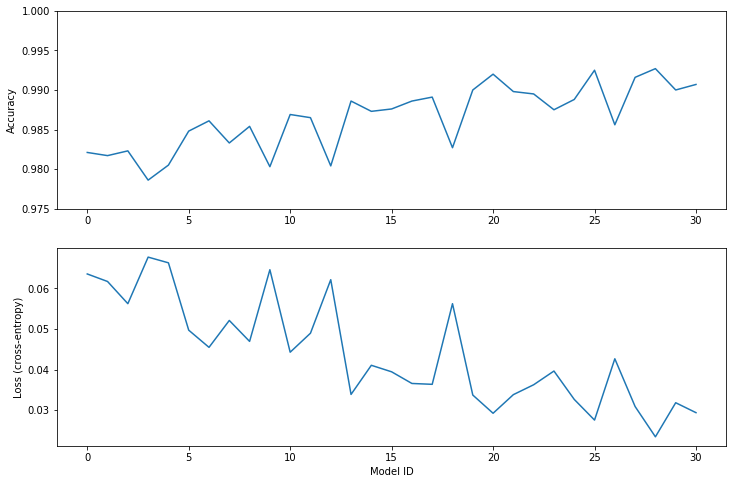

In [44]:
print("Search done in %ds"%sum(timing))

plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.plot(accuracies)
plt.ylabel("Accuracy")
plt.ylim(.975,1.)

plt.subplot(2,1,2)
plt.plot(losses);
plt.ylabel("Loss (cross-entropy)")
plt.xlabel("Model ID")

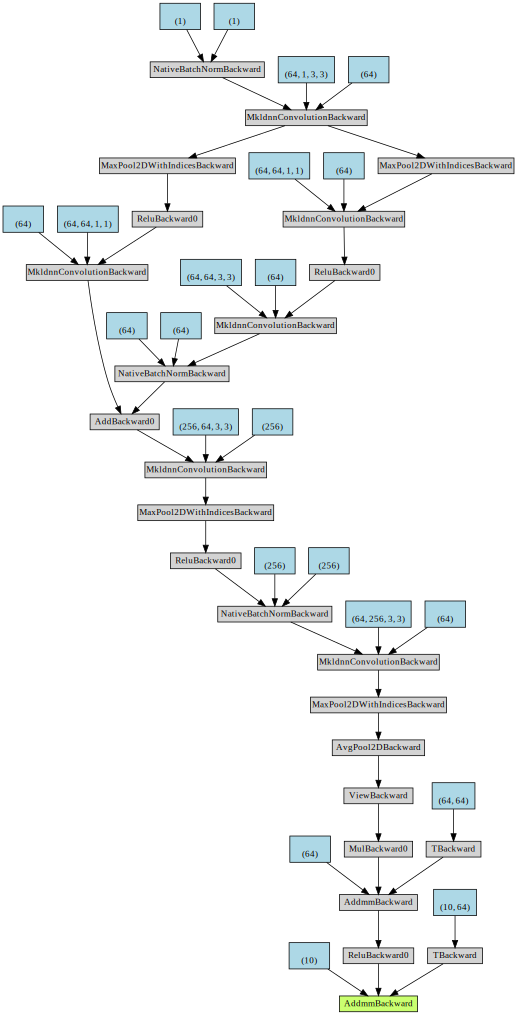

In [38]:
best_graph = tuner.load_best_model()
best_model = best_graph.produce_torch_model()

x,y = test_dataset[0]
x.unsqueeze_(0)
make_dot(best_model(x))